In [1]:
# import the module
import tweepy
from pathlib import Path 
import json

In [2]:
def get_twauth():
    path = Path('.') / '.env/twitter_keys.json'
    twitter_auth = json.load(open(path))
    return twitter_auth

tw_auth = get_twauth()

In [3]:
  
# assign the values accordingly
consumer_key = tw_auth['TWITTER_CONSUMER_KEY']
consumer_secret = tw_auth['TWITTER_CONSUMER_SECRET']
access_token = tw_auth['TWITTER_ACCESS_TOKEN']
access_token_secret = tw_auth['TWITTER_ACCESS_TOKEN_SECRET']


# authorization of consumer key and consumer secret
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
  
# set access to user's access key and access secret 
auth.set_access_token(access_token, access_token_secret)
  
# calling the api 
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True, compression=True)


In [31]:
twitter_screen_name = ['HotlineReid', 'benpolitico', 'daveweigel', 'fixfelicia', 'SusanPage', 'alex_wags', 'LarrySabato', 'cbellantoni', 'stevebenen', 'Atrios',
                      'fivethirtyeight', 'RasmussenPoll', 'ggreenwald', 'mikememoli', 'LamidiKehinde8', 'dmarinere', 'salisolar', 'geeksforgeeks', 'nicopitney',
                      'aproko_doctor', 'aycomdian']

In [32]:
# getting only 30 followers
screen_name_twitter = []
for screen_name in twitter_screen_name:
    try:
        for follower in tweepy.Cursor(api.followers, screen_name=screen_name).items(50):
            screen_name_twitter.append(follower.screen_name)
    except tweepy.TweepError:
        print(screen_name)

HotlineReid


Rate limit reached. Sleeping for: 850
Rate limit reached. Sleeping for: 853


RasmussenPoll


Rate limit reached. Sleeping for: 849
Rate limit reached. Sleeping for: 851


aycomdian


## User Based Features

In [35]:
import pandas as pd
# get no of followers
def fetch_user_based_features():
    followers_list, friends_count, created_at, statuses_count = [],[],[],[]
    for name in screen_name_twitter:
        try:
            # fetching the user
            user = api.get_user(name)

            # fetching the followers_count
            followers_list.append(user.followers_count)

            # fetching the followers_count
            friends_count.append(user.friends_count)

            # fetching datetime account was created
            created_at.append(user.created_at)

            # fetching the statuses count attributes
            statuses_count.append(user.statuses_count)

        except tweepy.TweepError:
            print(name)
            
    df = pd.DataFrame(data=zip(screen_name_twitter,followers_list, friends_count, created_at, statuses_count), 
                      columns=['screen_name', 'followers_count', 'friends_count', 'created_at', 'statuses_count'])
    
    df['account_age'] = 2021 - pd.to_datetime(df['created_at']).dt.year
    df['account_reputation'] = df['followers_count'] / (df['friends_count'] + df['followers_count'])
    
    df = df.query("statuses_count > 20 or followers_count > 20 or account_age > 0")
    
    return df

user_based_fe = fetch_user_based_features()

In [36]:
user_based_fe.shape

(779, 7)

In [37]:
user_based_fe.tail(10)

,screen_name,followers_count,friends_count,created_at,statuses_count,account_age,account_reputation
854,Oluwajo27749369,74,117,2020-09-20 21:12:42,806,1,0.387435
855,HolyAss8,365,318,2018-07-07 19:10:52,12407,3,0.534407
856,niwarinda,500,4361,2012-01-28 03:26:43,778,9,0.102859
857,RVendure,294,232,2021-01-12 07:58:04,621,0,0.558935
858,christo2225,1,63,2011-04-27 21:04:14,9,10,0.015625
859,legal_901,49,381,2012-04-01 10:11:06,476,9,0.113953
860,akodudles,43,292,2021-07-26 19:10:11,0,0,0.128358
861,TyenTristan,60,141,2019-03-30 14:44:47,25,2,0.298507
862,henrinointegri1,3,66,2021-04-20 15:07:20,78,0,0.043478
863,a_herbes,114,448,2021-02-04 20:57:33,47,0,0.202847


In [48]:
try:
    # fetching the user
    statuses = api.user_timeline(screen_name='aproko_doctor', count=5)
except tweepy.Error as e:
    print("Error:", e)

In [106]:
import preprocessor as p
import re
import string
from nltk.corpus import stopwords

def clean_tweets(twitter_text):

    #use pre processor
    tweet = p.clean(twitter_text)

     #HappyEmoticons
    emoticons_happy = set([
        ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
        ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
        '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
        'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
        '<3'
        ])

    # Sad Emoticons
    emoticons_sad = set([
        ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
        ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
        ':c', ':{', '>:\\', ';('
        ])

    #Emoji patterns
    emoji_pattern = re.compile("["
             u"\U0001F600-\U0001F64F"  # emoticons
             u"\U0001F300-\U0001F5FF"  # symbols & pictographs
             u"\U0001F680-\U0001F6FF"  # transport & map symbols
             u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
             u"\U00002702-\U000027B0"
             u"\U000024C2-\U0001F251"
             "]+", flags=re.UNICODE)

    #combine sad and happy emoticons
    emoticons = emoticons_happy.union(emoticons_sad)

    stop_words = set(stopwords.words('english'))
    word_tokens = nltk.word_tokenize(tweet)
    #after tweepy preprocessing the colon symbol left remain after      
    #removing mentions
    tweet = re.sub(r':', '', tweet)
    tweet = re.sub(r'‚Ä¶', '', tweet)

    #replace consecutive non-ASCII characters with a space
    tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet)

    #remove emojis from tweet
    tweet = emoji_pattern.sub(r'', tweet)

    #filter using NLTK library append it to a string
    filtered_tweet = [w for w in word_tokens if not w in stop_words]

    #looping through conditions
    filtered_tweet = []    
    for w in word_tokens:
    #check tokens against stop words , emoticons and punctuations
        if w not in stop_words and w not in emoticons and w not in string.punctuation:
            filtered_tweet.append(w)

    return ' '.join(filtered_tweet)

In [91]:

# results = [status._json for status in tweepy.Cursor(api.user_timeline, screen_name='aproko_doctor', count=10, tweet_mode='extended', lang='en').items()]

my_tweets = []
author_name = []
for result in results:
    my_tweets.append(result["full_text"])
    author_name.append(result['original_author'])


KeyError: 'original_author'

In [51]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
  

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/abubakar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/abubakar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [116]:
from textblob import TextBlob
class Tweet_df:
    """
    this function will parse tweets json into a pandas dataframe
    
    Return
    ------
    dataframe
    """
    def __init__(self, tweets_list):
        
        self.tweets_list = tweets_list

    def find_statuses_count(self)->list:
        statuses_count = [x['user']['statuses_count'] for x in self.tweets_list]

        return statuses_count
        
    def find_full_text(self)->list:
        text = [tweet['full_text'] for tweet in self.tweets_list]

        return text 
    
    def find_clean_text(self)->list:
        clean_text = [clean_tweets(tweet['full_text']) for tweet in self.tweets_list]
        
        return clean_text
    
    def find_sentiments(self, text:list)->list:
        polarity, subjectivity = [], []
        for tweet in text:
            blob = TextBlob(tweet)
            sentiment = blob.sentiment
            polarity.append(sentiment.polarity)
            subjectivity.append(sentiment.subjectivity)

        return polarity, subjectivity

    def find_created_time(self)->list:
        created_at = [x['created_at'] for x in self.tweets_list]

        return created_at

    def find_source(self)->list:
        source = [x['source'] for x in self.tweets_list]

        return source

    def find_screen_name(self)->list:
        screen_name = [x['user']['screen_name'] for x in self.tweets_list]

        return screen_name

    def find_followers_count(self)->list:
        followers_count = [x['user']['followers_count'] for x in self.tweets_list]

        return followers_count

    def find_friends_count(self)->list:
        friends_count = [x['user']['friends_count'] for x in self.tweets_list]

        return friends_count

    def is_sensitive(self)->list:
        is_sensitive = []
        for tweet in self.tweets_list:
            if 'possibly_sensitive' in tweet.keys():
                is_sensitive.append(tweet['possibly_sensitive'])
            else: is_sensitive.append(None)
    
        return is_sensitive
       

    def find_favourite_count(self)->list:
        favorite_count = []
        for tweet in self.tweets_list:
            if 'retweeted_status' in tweet.keys():
                favorite_count.append(tweet['retweeted_status']['favorite_count'])
            else: favorite_count.append(0)
    
        return favorite_count
    
    def find_retweet_count(self)->list:
        
        retweet_count = []
        for tweet in self.tweets_list:
            if 'retweeted_status' in tweet.keys():
                retweet_count.append(tweet['retweeted_status']['retweet_count'])
            else: retweet_count.append(0)
    
        return retweet_count

    def find_hashtags(self)->list:
        hashtags = []
        for tw in self.tweets_list:
            hashtags.append(", ".join([hashtag_item['text'] for hashtag_item in tw['entities']['hashtags']]))

        return hashtags

    def find_mentions(self)->list:
        mentions = []
        for tw in self.tweets_list:
            mentions.append( ", ".join([mention['screen_name'] for mention in tw['entities']['user_mentions']]))

        return mentions
    
    def find_lang(self)->list:
        lang = [x['lang'] for x in self.tweets_list]
        
        return lang

    def find_location(self)->list:
        location = []
        for tweet in self.tweets_list:
            location.append(tweet['user']['location'])
            
        return location
    
    def get_tweet_df(self)->pd.DataFrame:
        """required column to be generated you should be creative and add more features"""
        
        columns = ['created_at', 'source', 'original_text','clean_text', 'polarity','subjectivity', 'lang', 'favorite_count', 'retweet_count', 
            'original_author', 'followers_count','friends_count','possibly_sensitive', 'hashtags', 'user_mentions', 'place']
        
        created_at = self.find_created_time()
        source = self.find_source()
        text = self.find_full_text()
        clean_text = self.find_clean_text()
        polarity, subjectivity = self.find_sentiments(text)
        lang = self.find_lang()
        fav_count = self.find_favourite_count()
        retweet_count = self.find_retweet_count()
        screen_name = self.find_screen_name()
        follower_count = self.find_followers_count()
        friends_count = self.find_friends_count()
        sensitivity = self.is_sensitive()
        hashtags = self.find_hashtags()
        mentions = self.find_mentions()
        location = self.find_location()
        data = zip(created_at, source, text, clean_text, polarity, subjectivity, lang, fav_count, retweet_count, screen_name, 
                   follower_count, friends_count, sensitivity, hashtags, mentions, location)
        df = pd.DataFrame(data=data, columns=columns)
        
        df.to_csv('processed_tweet_data.csv', index=False)
        print('File Successfully Saved.!!!')
        
        return df
    
                    
if __name__ == "__main__":
    
    tweet = Tweet_df(results)
    n_df = tweet.get_tweet_df()


File Successfully Saved.!!!


In [133]:
from tweepy import Stream
from tweepy.streaming import StreamListener
election_keywords = ['Election', 'Election Nigeria', 'Electorate', 'Campaign Election', 'PDP Political Party', 
                  'Vote','Voting Nigeria', 'APC Political Party','Campaign Election Nigeria', 'Political Parties Nigeria',
                 'Government Election', 'Parliament Election',]

# ts = tweetsearch() 
class MyListener(StreamListener):
    
    def on_data(self, data):
        try:
            with open('election.json', 'a') as f:
                f.write(data)
                return True
        except BaseException as e:
            print(f"Error on_data: {e}")
            
        return True
    
    def on_error(self, status):
        print("Error", status)
        return True
    
twitter_stream = Stream(auth, MyListener())
twitter_stream.filter(track=election_keywords, is_async=True, languages=['en'])

Error 420
Error 420
Error 420
420
eeror 420


In [5]:
election_keywords = ['Election', 'Election Nigeria', 'Electorate', 'Campaign Election', 'PDP Political Party', 
                  'Vote','Voting Nigeria', 'APC Political Party','Campaign Election Nigeria', 'Political Parties Nigeria',
                 'Government Election', 'Parliament Election', '#electionNigeria', 'presidential']

In [35]:
# Collect tweets
date_since = "2020-11-16"

tweets = tweepy.Cursor(api.search,
              q='APC' + " -filter:retweets",
              lang="en",
              since=date_since, geocode="6.48937, 3.37709, 4km").items(5)

# Iterate and print tweets
for tweet in tweets:
    print(tweet.text, tweet.user.screen_name)
    


In [54]:
import preprocessor as p
import re
import string
from nltk.corpus import stopwords
from textblob import TextBlob

def clean_tweets(twitter_text):

    #use pre processor
    tweet = p.clean(twitter_text)

     #HappyEmoticons
    emoticons_happy = set([
        ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
        ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
        '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
        'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
        '<3'
        ])

    # Sad Emoticons
    emoticons_sad = set([
        ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
        ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
        ':c', ':{', '>:\\', ';('
        ])

    #Emoji patterns
    emoji_pattern = re.compile("["
             u"\U0001F600-\U0001F64F"  # emoticons
             u"\U0001F300-\U0001F5FF"  # symbols & pictographs
             u"\U0001F680-\U0001F6FF"  # transport & map symbols
             u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
             u"\U00002702-\U000027B0"
             u"\U000024C2-\U0001F251"
             "]+", flags=re.UNICODE)

    #combine sad and happy emoticons
    emoticons = emoticons_happy.union(emoticons_sad)

    stop_words = set(stopwords.words('english'))
    word_tokens = nltk.word_tokenize(tweet)
    #after tweepy preprocessing the colon symbol left remain after      
    #removing mentions
    tweet = re.sub(r':', '', tweet)
    tweet = re.sub(r'‚Ä¶', '', tweet)

    #replace consecutive non-ASCII characters with a space
    tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet)

    #remove emojis from tweet
    tweet = emoji_pattern.sub(r'', tweet)

    #filter using NLTK library append it to a string
    filtered_tweet = [w for w in word_tokens if not w in stop_words]

    #looping through conditions
    filtered_tweet = []    
    for w in word_tokens:
    #check tokens against stop words , emoticons and punctuations
        if w not in stop_words and w not in emoticons and w not in string.punctuation:
            filtered_tweet.append(w)

    return ' '.join(filtered_tweet)            


In [42]:
cols = ['id', 'created_at', 'source', 'original_text','clean_text', 
                    'sentiment','polarity','subjectivity', 'lang',
                    'favorite_count', 'retweet_count', 'original_author', 'screen_count',
                    'followers_count','friends_count','possibly_sensitive', 'hashtags',
                    'user_mentions', 'place', 'place_coord_boundaries']
            

In [49]:
def get_tweets(keyword, csvfile=None):


    df = pd.DataFrame(columns=cols)


    #page attribute in tweepy.cursor and iteration
    for page in tweepy.Cursor(api.search, q=keyword, count=140, include_rts=False, lang='en', tweet_mode='extended').pages():

        # the you receive from the Twitter API is in a JSON format and has quite an amount of information attached
        for status in page:

            new_entry = []
            status = status._json

            #if this tweet is a retweet update retweet count
            if status['created_at'] in df['created_at'].values:
                i = df.loc[df['created_at'] == status['created_at']].index[0]
                #
                cond1 = status['favorite_count'] != df.at[i, 'favorite_count']
                cond2 = status['retweet_count'] != df.at[i, 'retweet_count']
                if cond1 or cond2:
                    df.at[i, 'favorite_count'] = status['favorite_count']
                    df.at[i, 'retweet_count'] = status['retweet_count']
                continue

            #calculate sentiment
            filtered_tweet = clean_tweets(status['full_text'])
            blob = TextBlob(filtered_tweet)
            Sentiment = blob.sentiment     
            polarity = Sentiment.polarity
            subjectivity = Sentiment.subjectivity

            new_entry += [status['id'], status['created_at'],
                          status['source'], status['full_text'], filtered_tweet, 
                          Sentiment,polarity,subjectivity, status['lang'],
                          status['favorite_count'], status['retweet_count']]

            new_entry.append(status['user']['screen_name'])
            new_entry.append(status['user']['statuses_count'])
            new_entry.append(status['user']['followers_count'])
            new_entry.append(status['user']['friends_count'])


            try:
                is_sensitive = status['possibly_sensitive']
            except KeyError:
                is_sensitive = None

            new_entry.append(is_sensitive)

            hashtags = ", ".join([hashtag_item['text'] for hashtag_item in status['entities']['hashtags']])
            new_entry.append(hashtags) #append the hashtags

            #
            mentions = ", ".join([mention['screen_name'] for mention in status['entities']['user_mentions']])
            new_entry.append(mentions) #append the user mentions

            try:
                xyz = status['place']['bounding_box']['coordinates']
                coordinates = [coord for loc in xyz for coord in loc]
            except TypeError:
                coordinates = None
            #
            new_entry.append(coordinates)

            try:
                location = status['user']['location']
            except TypeError:
                location = ''
            #
            new_entry.append(location)

            #now append a row to the dataframe
            single_tweet_df = pd.DataFrame([new_entry], columns=cols)
            df = df.append(single_tweet_df, ignore_index=True)

    #
    df['timestamp'] = df.created_at.map(pd.Timestamp)
    df = df.sort_values('timestamp').set_index('timestamp')
    df = df.drop('id',axis=1)
#         print(df.shape[0]) 

    if not csvfile is None:
        #save it to file
        df.to_csv(csvfile,mode='a', index=True, encoding="utf-8")
#             print(df.shape[0])


    return df 

In [55]:
all_list_of_places = ['Nigeria', 'Lagos', 'Abuja', 'Ibadan']
additional = ['Governor', 'campaign', 'electorates']
def election_tweets(list_of_places):
    file_name = "Election.csv"
            
    for place in list_of_places:
        for item in additional:
            keywords = ['Election',place,item]
            final_keywords = " AND ".join(keywords)
            try:
                df = get_tweets(keyword=final_keywords, csvfile=file_name)
                print(final_keywords)
            except tweepy.TweepError:
                continue

    for keyword in election_keywords:
        for place in list_of_places:
            keywords = [keyword,place]
            final_keywords = " AND ".join(keywords)
            try:
                df = get_tweets(final_keywords, csvfile=file_name)
                print(final_keywords)
            except tweepy.TweepError:
                continue

election_tweets(all_list_of_places)

Election AND Nigeria AND Governor
Election AND Nigeria AND campaign
Election AND Nigeria AND electorates
Election AND Lagos AND Governor
Election AND Lagos AND campaign
Election AND Lagos AND electorates
Election AND Abuja AND Governor
Election AND Abuja AND campaign
Election AND Abuja AND electorates
Election AND Ibadan AND Governor
Election AND Ibadan AND campaign
Election AND Ibadan AND electorates
Election AND Nigeria
Election AND Lagos
Election AND Abuja
Election AND Ibadan
Election Nigeria AND Nigeria
Election Nigeria AND Lagos
Election Nigeria AND Abuja
Election Nigeria AND Ibadan
Electorate AND Nigeria
Electorate AND Lagos
Electorate AND Abuja
Electorate AND Ibadan
Campaign Election AND Nigeria


Rate limit reached. Sleeping for: 635


Campaign Election AND Lagos
Campaign Election AND Abuja
Campaign Election AND Ibadan
PDP Political Party AND Nigeria
PDP Political Party AND Lagos
PDP Political Party AND Abuja
PDP Political Party AND Ibadan
Vote AND Nigeria
Vote AND Lagos
Vote AND Abuja
Vote AND Ibadan
Voting Nigeria AND Nigeria
Voting Nigeria AND Lagos
Voting Nigeria AND Abuja
Voting Nigeria AND Ibadan
APC Political Party AND Nigeria
APC Political Party AND Lagos
APC Political Party AND Abuja
APC Political Party AND Ibadan
Campaign Election Nigeria AND Nigeria
Campaign Election Nigeria AND Lagos
Campaign Election Nigeria AND Abuja
Campaign Election Nigeria AND Ibadan
Political Parties Nigeria AND Nigeria
Political Parties Nigeria AND Lagos
Political Parties Nigeria AND Abuja
Political Parties Nigeria AND Ibadan
Government Election AND Nigeria
Government Election AND Lagos
Government Election AND Abuja
Government Election AND Ibadan
Parliament Election AND Nigeria
Parliament Election AND Lagos
Parliament Election AND 

In [56]:
df_election = pd.read_csv('Election.csv')
df_election.head(10)

,timestamp,created_at,source,original_text,clean_text,sentiment,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,screen_count,followers_count,friends_count,possibly_sensitive,hashtags,user_mentions,place,place_coord_boundaries
0,2021-07-24 11:58:01+00:00,Sat Jul 24 11:58:01 +0000 2021,"<a href=""http://twitter.com/download/iphone"" r...",@fueksy LG election is just waste of time….APC...,LG election waste time.APC win local govt gove...,"Sentiment(polarity=0.20000000000000004, subjec...",0.20000000000000004,0.13333333333333333,en,0,0,Chuckobi1,11359,67,51,NaN,NaN,fueksy,NaN,NaN
1,2021-07-24 12:15:47+00:00,Sat Jul 24 12:15:47 +0000 2021,"<a href=""http://twitter.com/download/android"" ...",@DokunOjomo @youthparty_ng Local government el...,Local government elections predictable electio...,"Sentiment(polarity=0.016666666666666663, subje...",0.016666666666666663,0.27777777777777773,en,0,0,jidecole20,13130,371,2648,NaN,NaN,"DokunOjomo, youthparty_ng",NaN,NaN
2,2021-07-24 15:45:02+00:00,Sat Jul 24 15:45:02 +0000 2021,"<a href=""http://twitter.com/download/android"" ...",RT @thefactcheckhub: #FACTCHECK: A former Depu...,A former Deputy Governor 's Central Bank said ...,"Sentiment(polarity=0.0, subjectivity=0.125)",0.0,0.125,en,0,38,TheICIR,40079,25452,124,NaN,"FACTCHECK, Nigeria","thefactcheckhub, MoghaluKingsley",NaN,"Abuja, Nigeria"
3,2021-07-24 16:12:06+00:00,Sat Jul 24 16:12:06 +0000 2021,"<a href=""http://twitter.com/download/android"" ...",RT @Omambala_Chuks: #RT @MrSomtoOkonkwo: 'I Do...,I Do n't Fear Anybody You Only Die Once Govern...,"Sentiment(polarity=0.0, subjectivity=1.0)",0.0,1.0,en,0,14,du_raymond,245741,1250,420,NaN,RT,Omambala_Chuks,NaN,"Aba Nigeria , Abia State"
4,2021-07-24 16:47:42+00:00,Sat Jul 24 16:47:42 +0000 2021,"<a href=""http://twitter.com/download/android"" ...",@REPERCUSSIONS87 @Tutsy22 There is SELECTION i...,There SELECTION Lagos today ... mean Local gov...,"Sentiment(polarity=0.1375, subjectivity=0.4852...",0.1375,0.4852777777777778,en,26,0,NobleKennyOA,2049,421,430,NaN,NaN,"REPERCUSSIONS87, Tutsy22",NaN,NaN
5,2021-07-24 18:21:18+00:00,Sat Jul 24 18:21:18 +0000 2021,"<a href=""http://twitter.com/download/android"" ...",(ATURU FULANI- fool Uzodinma)is a Nigerian pol...,ATURU FULANI- fool Uzodinma Nigerian politicia...,"Sentiment(polarity=0.0, subjectivity=0.0)",0.0,0.0,en,0,0,Saleitdirectcom,538,3,6,False,NaN,NaN,NaN,"Hamburg, Deutschland"
6,2021-07-25 01:20:44+00:00,Sun Jul 25 01:20:44 +0000 2021,"<a href=""http://twitter.com/download/android"" ...",@_SirWilliam_ Of what use is your vote in a lo...,Of use vote local government election Nigeria ...,"Sentiment(polarity=0.26666666666666666, subjec...",0.26666666666666666,0.16666666666666666,en,0,0,lucky_mikoyo,4717,99,190,NaN,NaN,_SirWilliam_,NaN,NaN
7,2021-07-27 19:42:50+00:00,Tue Jul 27 19:42:50 +0000 2021,"<a href=""https://mobile.twitter.com"" rel=""nofo...","Buhari, originally from Niger Republic is Pres...",Buhari originally Niger Republic President Nig...,"Sentiment(polarity=0.375, subjectivity=0.75)",0.375,0.75,en,1,3,Demoore90210,139000,5134,1015,False,NaN,NaN,NaN,🇬🇧🇳🇬
8,2021-07-27 19:50:13+00:00,Tue Jul 27 19:50:13 +0000 2021,"<a href=""http://twitter.com/download/android"" ...","RT @Demoore90210: Buhari, originally from Nige...",Buhari originally Niger Republic President Nig...,"Sentiment(polarity=0.375, subjectivity=0.75)",0.375,0.75,en,0,3,ariselightup,27683,187,903,NaN,NaN,Demoore90210,NaN,Nigeria
9,2021-07-27 19:58:10+00:00,Tue Jul 27 19:58:10 +0000 2021,"<a href=""http://twitter.com/download/android"" ...","RT @Demoore90210: Buhari, originally from Nige...",Buhari originally Niger Republic President Nig...,"Sentiment(polarity=0.375, subjectivity=0.75)",0.375,0.75,en,0,3,ihmcleancare,136203,305,2273,NaN,NaN,Demoore90210,NaN,NaN


In [57]:
df_election['clean_text'].sample(10)

26051    One greatest Nigeria political campaign I 've ...
9571     Breaking ABUBAKAR DUUWALE man trekked Yola Abu...
26492    What happened Lagos Local Government election ...
8847     Good Evening SirI hope meet well.Election ende...
14113    Only Nigeria Professors rig election politicia...
23762    Not register vote boycott elections marginaliz...
10115    Breaking ABUBAKAR DUUWALE man trekked Yola Abu...
27664    What happened Lagos Local Government election ...
1417     If actually want see improved Education Health...
4784     This long read If love Nigerian sports kindly ...
Name: clean_text, dtype: object

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

class Automation:
    """
    The PEP8 Standard AMAZING!!!
    """
    def __init__(self):
        print('Automation in Action...!!!')

    def Clean_Tweets(self, df):
        # drop na in clean tweets column
        a = df[df['retweet_count'] == 'retweet_count' ].index
        df.drop(a , inplace=True)
        # dropduplicates and drop duplicates in clean tweets
        df = df.drop_duplicates().drop_duplicates(subset='clean_text')
        # convert int column appropriately
        df = df[df['polarity'] != 'polarity']
        # convert the created_at column to a datetime object
        df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
        df['timestamp'] = df['timestamp'].dt.strftime('%Y-%m-%d')
        df = df[df['created_at'] >= '2020-12-31' ]
        # convert int column appropriately
        df['polarity'] = pd.to_numeric(df['polarity'], errors='coerce')
        df['subjectivity'] = pd.to_numeric(df['subjectivity'], errors='coerce')
        df['retweet_count'] = pd.to_numeric(df['retweet_count'], errors='coerce')
        df['favorite_count'] = pd.to_numeric(df['favorite_count'], errors='coerce')
        return df

    def Time_Trend(self, df, city,x):
        ax = df.groupby('created_at')[['retweet_count', 'favorite_count']].sum().plot(figsize=(20,8))
        plt.title(f'Trend of likes and retweets for {city}', size=20)
        plt.axvline(x=x,color='gray',linestyle='--')
        plt.ylabel('Frequency', fontsize=14)
        plt.xlabel('Time', fontsize=14)
        plt.xticks(rotation=45)
        plt.show()
        
        
    def Draw_Wordcloud(self, tweets_series, description):
        # word cloud visualization
        allWords = ' '.join([twts for twts in tweets_series])
        stopwords = list(STOPWORDS) + ["https", 'http', 't', 'amp', 'rt']
        wordCloud = WordCloud(width=500, height=300, random_state=21, max_font_size=110, stopwords=stopwords, collocations=False).generate(allWords)
        plt.figure(figsize=(15, 12))
        plt.imshow(wordCloud, interpolation="bilinear")
        plt.axis('off')
        plt.title(f'Most used words describing {description}', size=20)
        plt.show()
        

In [59]:
auto = Automation()

Automation in Action...!!!


In [60]:
df = auto.Clean_Tweets(df_election)

In [61]:
df_election.shape, df.shape

((27945, 20), (2895, 20))

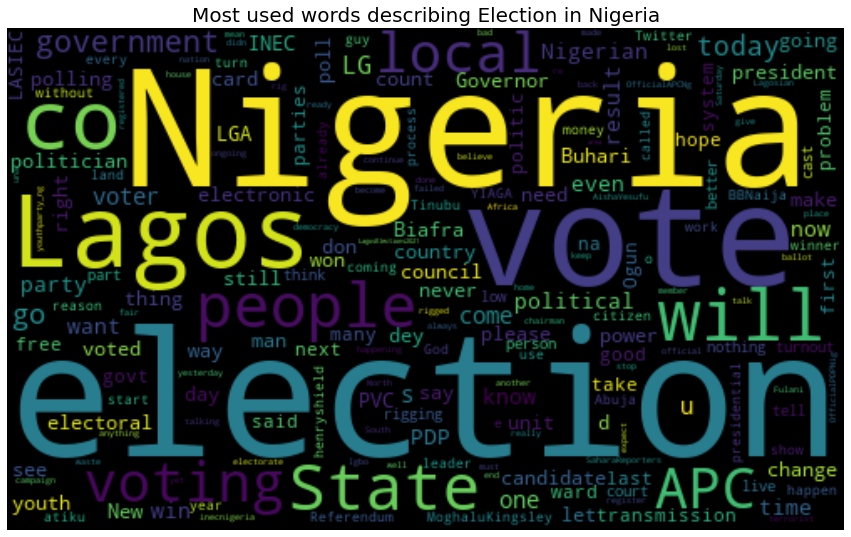

In [62]:
auto.Draw_Wordcloud(df['original_text'], 'Election in Nigeria')


In [102]:
df['category'] = 'not spam'

text = df[['clean_text', 'category']].copy()

In [96]:
text.shape

(2895, 2)

In [124]:
spam = pd.read_csv('spam.csv',  encoding = 'latin-1').query('v1 == "spam" ')[['v2', 'v1']]
spam.columns = ['clean_text', 'category']

In [125]:
spam.shape

(747, 2)

In [126]:
spam.head()

,clean_text,category
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
5,FreeMsg Hey there darling it's been 3 week's n...,spam
8,WINNER!! As a valued network customer you have...,spam
9,Had your mobile 11 months or more? U R entitle...,spam
11,"SIX chances to win CASH! From 100 to 20,000 po...",spam


In [127]:
text.head()

,clean_text,category
0,LG election waste time.APC win local govt gove...,not spam
1,Local government elections predictable electio...,not spam
2,A former Deputy Governor 's Central Bank said ...,not spam
3,I Do n't Fear Anybody You Only Die Once Govern...,not spam
4,There SELECTION Lagos today ... mean Local gov...,not spam


In [128]:
text1 = text.append(spam)

text1.shape

(3642, 2)

In [133]:
text1.to_csv('election_data.csv', index=False)